In [1]:
import urllib2
from bs4 import BeautifulSoup
import itertools
import time

import psycopg2
import pandas as pd
import numpy as np
import sqlalchemy as sa
from sqlalchemy_utils import database_exists, create_database

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = 12, 8  # plotsize
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['lines.color'] = 'r'
plt.rcParams['font.size'] = 14

pd.set_option('display.max_columns', 500)

In [2]:
# For later page i: use page1 + "&start=" + str(50*i)

def Scrape_Indeed(resume_search_page1,total_resumes=950):
    resume_per_page = 50
    npages = total_resumes/resume_per_page + (total_resumes%resume_per_page>0)

    resume_links=[]
    prefix = 'http://www.indeed.com'
    print "starting downloading "+resume_search_page1 
    for i in range(npages):
        search_page = resume_search_page1 if i==0 else (resume_search_page1 + "&start=" + str(50*i))

        try:
            page = urllib2.urlopen( search_page )
        except:
            print 'Error openning'+ search_page 
            continue
            
        soup = BeautifulSoup(page,"html.parser")
        #print soup.prettify()
        all_links=soup.find_all('a',class_='app_link')
#        print len(all_links) # expect 50 resumes per page

        for link in all_links:
            href = prefix + link.get("href")
            if href not in resume_links:  # somehow, some resumes show up more than once
                resume_links.append(href)
        
        time.sleep(1)
    return resume_links    

In [3]:
# http for selected hot jobs

# 1. Data Scientist
DS1=(985, 'http://www.indeed.com/resumes?q=title%3A(data+scientist)&co=US&rb=yoe%3A25')

# 2. Software Engineer
SE1=(1000, 'http://www.indeed.com/resumes?q=title%3A(Senior+Software+Engineer)&co=US&rb=jtid%3A1422%2Cyoe%3A61-120')

# 3. Consultant
Con1=(1000, 'http://www.indeed.com/resumes?q=title%3AConsultant&co=US&rb=jtid%3A281%7C2051%2Cyoe%3A61-120')

# 4. Strategy Manager
SM1=(1000, 'http://www.indeed.com/resumes?q=%22Strategy+Manager%22+-Consultant+anytitle%3A%28Strategy+Manager%29&co=US')

In [4]:
Jobs=['Data Scientist','Software Engineer','Consultant','Strategy Manager']
print(len(Jobs))
Links=[DS1,SE1,Con1,SM1]
print(len(Links))

4
4


In [5]:
resume_links=[]
job_classes=[]

for i,(npages, link) in enumerate(Links):
    t=time.time()
    
    html_link=Scrape_Indeed(link,npages)
    html_link=list(set(html_link))
    nresumes=len(html_link)
    
    job_classes.append([Jobs[i]]*nresumes)
    resume_links.append( html_link )
    
    elapsed = (time.time() - t)/60    
    print "Done with %d %s resumes in %.2f!"%(nresumes,Jobs[i],elapsed)
    
resume_links = list(itertools.chain(*resume_links))
job_classes = list(itertools.chain(*job_classes))

starting downloading http://www.indeed.com/resumes?q=title%3A(data+scientist)&co=US&rb=yoe%3A25
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
35
Done with 717 Data Scientist resumes in 0.55!
starting downloading http://www.indeed.com/resumes?q=title%3A(Senior+Software+Engineer)&co=US&rb=jtid%3A1422%2Cyoe%3A61-120
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
Done with 808 Software Engineer resumes in 0.58!
starting downloading http://www.indeed.com/resumes?q=title%3AConsultant&co=US&rb=jtid%3A281%7C2051%2Cyoe%3A61-120
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
Done with 802 Consultant resumes in 0.76!
starting downloading http://www.indeed.com/resumes?q=%22Strategy+Manager%22+-Consultant+anytitle%3A%28Strategy+Manager%29&co=US
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
Done with 751 Strategy Manager resumes in 0.70!


In [6]:
print len(resume_links)
print len(job_classes)

3078
3078


In [7]:
job_classes[:5]

['Data Scientist',
 'Data Scientist',
 'Data Scientist',
 'Data Scientist',
 'Data Scientist']

## Create database to store resume links

In [8]:
IndeedResume = sa.create_engine("postgres://%s@localhost/%s"%('hxzheng','indeed'))
## create a database (if it doesn't exist)
if not database_exists(IndeedResume.url):
    create_database(IndeedResume.url)
print(database_exists(IndeedResume.url))

True


In [9]:
indeed_df = pd.DataFrame(resume_links, columns = ['resume_url'])
indeed_df['job_class']=job_classes
indeed_df.to_sql('resume_table2', IndeedResume, if_exists='replace')

In [10]:
con = psycopg2.connect(database = 'indeed', user ='hxzheng',host='/tmp/')

sql_query = """
SELECT * FROM resume_table2;
"""
resumes = pd.read_sql_query(sql_query,con)
resumes.head()

,index,resume_url,job_class
0,0,http://www.indeed.com/r/Vikas-Patil/d9dc3f1bd6...,Data Scientist
1,1,http://www.indeed.com/r/Robert-Sousek/f78d89b0...,Data Scientist
2,2,http://www.indeed.com/me/Kris_I_Ford?sp=0,Data Scientist
3,3,http://www.indeed.com/r/Joydeep-Singh/ca6d4c0d...,Data Scientist
4,4,http://www.indeed.com/r/Ahmad-Nahhas/b9b9970cc...,Data Scientist


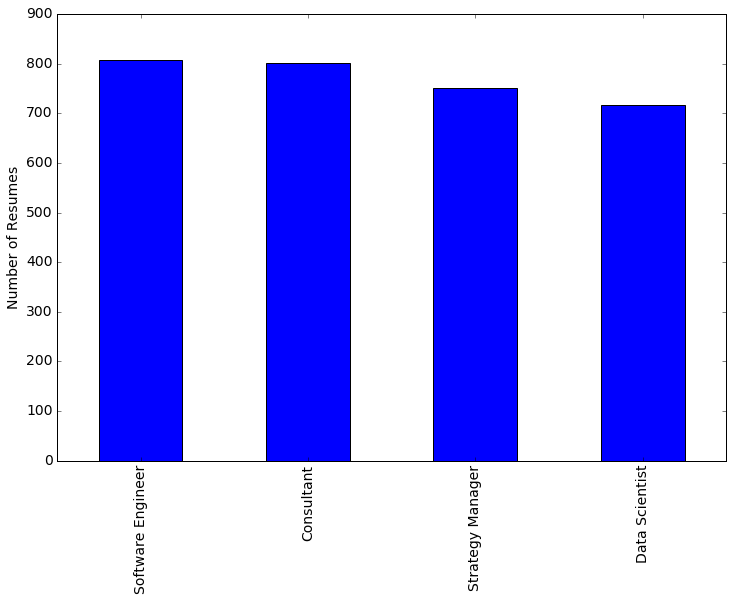

In [11]:
histgram_jobclass=resumes['job_class'].value_counts().plot(kind='bar')
histgram_jobclass.set_ylabel('Number of Resumes')